# Healthy or not !

In [1]:
from fastai import *
from fastai.vision import *
import datetime

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [2]:
folder = 'healthy'
#file = 'healthy_food.txt'

In [3]:
folder = 'junk'
#file = 'junk_food.txt'

You will need to run this line once per each category.

In [3]:
path = Path('/home/jupyter/data/food_new')
dest = path/folder
#dest.mkdir(parents=True, exist_ok=True)

In [4]:
classes = ['healthy','junk']

## Download images

In [5]:
#download_images(path/file, dest, max_pics=1000)

In [10]:
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [27]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

healthy


junk


## View data

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [7]:
data.classes

['healthy', 'junk']

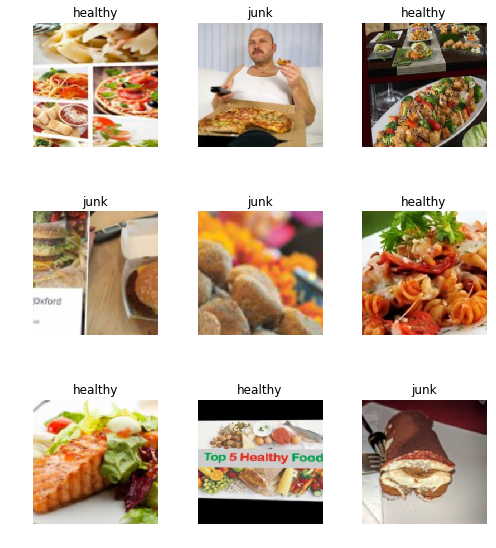

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [42]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['healthy', 'junk'], 2, 4759, 1225)

## Train model

In [8]:
model="resnet50"

In [9]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [10]:
learn.fit_one_cycle(5)

Total time: 04:05
epoch  train_loss  valid_loss  error_rate
1      0.590317    0.438903    0.190204    (00:54)
2      0.459277    0.390305    0.175510    (00:47)
3      0.394595    0.356796    0.160000    (00:47)
4      0.335818    0.348103    0.155918    (00:47)
5      0.295867    0.345652    0.151837    (00:47)



In [12]:
now = datetime.datetime.now().strftime ("%Y%m%d-%H%M")

In [10]:
learn.save("/home/jupyter/data/food_new/weights/" + model + "-stage-1-" + "Nov5")
#learn.load("/home/jupyter/data/food_new/weights/resnet50-stage-1-Nov5")

In [11]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


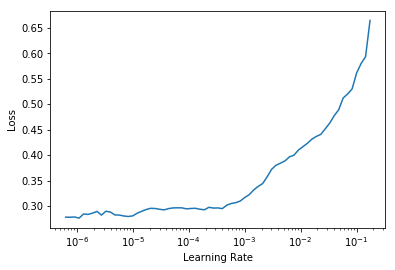

In [15]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-5))

Total time: 05:24
epoch  train_loss  valid_loss  error_rate
1      0.281025    0.336243    0.150204    (01:12)
2      0.279993    0.331554    0.142041    (01:03)
3      0.263077    0.334678    0.146122    (01:02)
4      0.242763    0.333072    0.147755    (01:02)
5      0.230772    0.336535    0.147755    (01:02)



In [16]:
learn.save("/home/jupyter/data/food_new/weights/" + model + "-stage-2" + "")

## Interpretation

In [8]:
#learn.load("/home/jupyter/data/food_new/weights/" + model + "-stage-1-" + now)
learn.load("/home/jupyter/data/food_new/weights/resnet50-stage-2_with_greens")

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

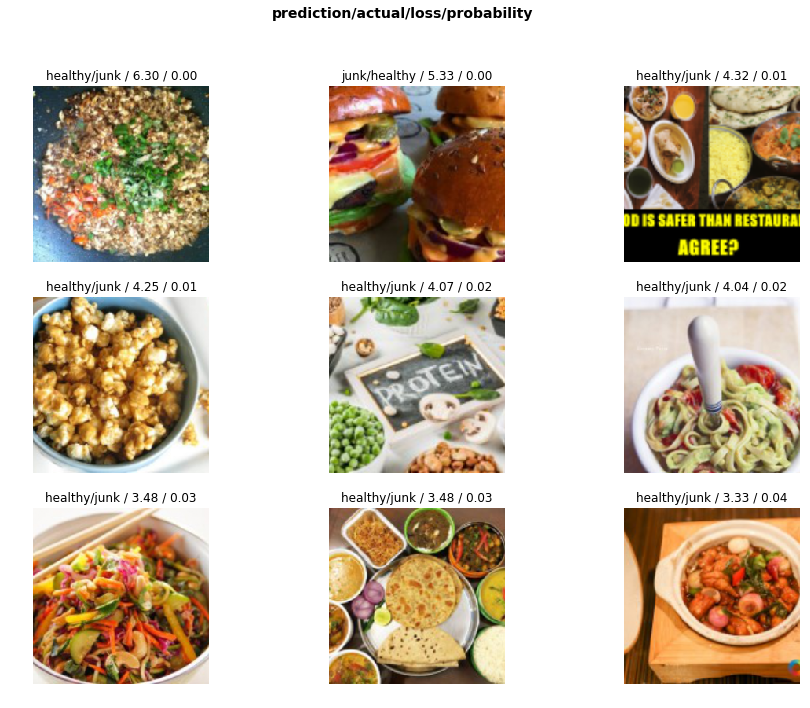

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

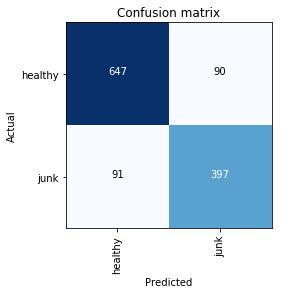

In [15]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [16]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [17]:
#interp.plot_top_losses(100)
#losses,idxs = interp.top_losses()
#top_loss_paths = data.valid_ds.x[idxs]
top_loss_paths[:]

array([PosixPath('/home/jupyter/data/food_new/junk/junk_chinese_000234.jpg'),
       PosixPath('/home/jupyter/data/food_new/healthy/00000372.jpg'),
       PosixPath('/home/jupyter/data/food_new/junk/junk_indian_000458.jpg'),
       PosixPath('/home/jupyter/data/food_new/junk/junk_american_000429.jpg'), ...,
       PosixPath('/home/jupyter/data/food_new/healthy/healthy_greens_000440.jpg'),
       PosixPath('/home/jupyter/data/food_new/junk/00000758.jpg'),
       PosixPath('/home/jupyter/data/food_new/healthy/00000144.jpg'),
       PosixPath('/home/jupyter/data/food_new/healthy/healthy_greens_000173.jpg')], dtype=object)

Now we can pass in these paths to our widget.

In [27]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

## Putting your model in production

In [28]:
data.classes

['healthy', 'junk']

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [29]:
# fastai.defaults.device = torch.device('cpu')

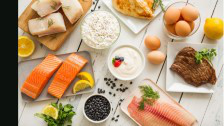

In [30]:
img = open_image(path/'healthy'/'00000086.jpg')
img

In [31]:
classes = ['healthy', 'junk']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet50)
learn.load("/home/jupyter/data/food_new/weights/" + model + "-stage-2")

In [32]:
pred_class,pred_idx,outputs = learn.predict(img)
#preds = learn.get_preds()
#interp2 = ClassificationInterpretation(data2,F.softmax(preds[0],1),preds[1],loss_class=nn.CrossEntropyLoss,sigmoid=False)
pred_class

'healthy'

In [33]:
outputs

tensor([16.5770,  0.0496])

In [31]:
outputs_softmax = torch.nn.functional.softmax(outputs, dim=0)
print("outputs_softmax: ", outputs_softmax)
#result = [x * 100 for x in outputs_softmax.numpy()]
#print("Result: ", result)
new_datalist = ["{:.1f}%".format(value) for value in [x * 100 for x in torch.nn.functional.softmax(outputs, dim=0)]]
#result = np.round(result, decimals=2)
#mylist = result.tolist()
print("mylist: ", new_datalist)

outputs_softmax:  tensor([1.0000e+00, 5.8147e-08])
mylist:  ['100.0%', '0.0%']


So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [0]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



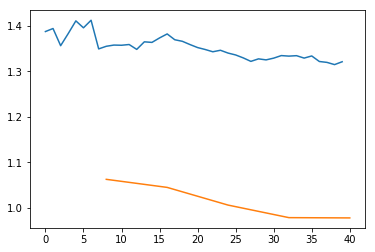

In [0]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [0]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2